# Mathematical Engineering - Financial Engineering, FY 2024-2025
# Final Project


In [17]:
# Importing the libraries

%reset -f
import numpy as np
import pandas as pd

from scipy.stats import norm
from boot import bootstrap
from project_functions import (
    compute_VaR_for_rho,
    business_date_offset,
    getDiscount,
    calibrate_rho
)

In [18]:

# Joint migration matrix
joint_counts = pd.DataFrame(
    {
        'AAA':     [0, 0, 0, 0, 0, 0, 0, 0],
        'AA':      [0, 15, 978, 12436, 839, 175, 55, 29],
        'A':       [0, 1105, 44523, 621477, 41760, 7081, 2230, 981],
        'BBB':     [0, 54, 2812, 40584, 2921, 532, 127, 67],
        'BB':      [0, 4, 414, 5075, 321, 76, 18, 7],
        'B':       [0, 0, 224, 2507, 193, 48, 15, 0],
        'CCC':     [0, 0, 0, 0, 0, 0, 0, 0],
        'Default': [0, 0, 0, 0, 0, 0, 0, 0]
    },
    index=['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Default']
)

# total number of cases
N = joint_counts.values.sum()

# Historically tabulated joint credit quality co-movement
empirical_joint_prob=joint_counts/N

marginal_A = empirical_joint_prob.sum(axis=0).values  # somma righe
marginal_BBB = empirical_joint_prob.sum(axis=1).values  # somma colonne

# CDF e soglie z
cdf_A = np.cumsum(marginal_A)
cdf_BBB = np.cumsum(marginal_BBB)
z_A = np.concatenate(([-np.inf], norm.ppf(cdf_A)))
z_BBB = np.concatenate(([-np.inf], norm.ppf(cdf_BBB)))

In [20]:
modes = ['MSE', 'MAE', 'likelihood', 'KL', 'JSD', 'weighted MAE', 'weighted MSE']

# modes = ['MSE']

P_results = []

for mode in modes:
    rho, loss = calibrate_rho(empirical_joint_prob.values, z_BBB, z_A, mode)

    result = {
        'mode': mode,
        'rho': rho,
        'loss': loss
    }
    P_results.append(result)

    print(f"Mode: {mode:<15} | Calibrated ρ(3m) = {rho:.6f} | Loss = {loss:.8e}")

# Estrai tutti i valori di ρ in un array numpy
rhos = np.array([res['rho'] for res in P_results])


Mode: MSE             | Calibrated ρ(3m) = 0.013835 | Loss = 2.78983224e-07
Mode: MAE             | Calibrated ρ(3m) = 0.017707 | Loss = 1.84677172e-03
Mode: likelihood      | Calibrated ρ(3m) = 0.007073 | Loss = 9.31956788e-01
Mode: KL              | Calibrated ρ(3m) = 0.007073 | Loss = 6.52646623e-05
Mode: JSD             | Calibrated ρ(3m) = 0.007172 | Loss = 1.71080803e-05
Mode: weighted MAE    | Calibrated ρ(3m) = 0.020228 | Loss = 1.43237602e-02
Mode: weighted MSE    | Calibrated ρ(3m) = 0.015097 | Loss = 2.00407924e-06


In [21]:

def extract_data(file_path):
    df_cleaned = pd.read_excel(file_path, sheet_name="Sheet1")

    # Extraction of dates

    settlement_date = df_cleaned.iloc[6, 4]
    depos_dates = df_cleaned.iloc[9:15, 3].tolist()
    futures_dates = df_cleaned.iloc[10:19, 16:18].values.tolist()
    swaps_dates = df_cleaned.iloc[37:54, 3].tolist()

    # Extraction of deposit rates
    depos_rates = df_cleaned.iloc[9:15, 7:9].values
    depos_rates = np.array(depos_rates, dtype=np.float64) / 100  # Conversion to float

    # Extraction of futures rates
    futures_rates = df_cleaned.iloc[26:35, 7:9].values
    futures_rates = np.array(futures_rates, dtype=np.float64) / 100  # Conversion to float

    # Extraction of swap rates
    swaps_rates = df_cleaned.iloc[37:54, 7:9].values
    swaps_rates = np.array(swaps_rates, dtype=np.float64) / 100  # Conversion to float

    return {
        "settlement_date": settlement_date,
        "depos_dates": depos_dates,
        "futures_dates": futures_dates,
        "swaps_dates": swaps_dates,
        "depos_rates": depos_rates,
        "futures_rates": futures_rates,
        "swaps_rates": swaps_rates
    }

# Extract from file excel
file_path = "MktData_CurveBootstrap.xls"
data = extract_data(file_path)


#  Create the `dates_set` dictionary containing the extracted dates
dates_set = {
    'settlement': data['settlement_date'],
    'depos': data['depos_dates'],
    'futures': data['futures_dates'],
    'swaps': data['swaps_dates']
}
# Create the `rates_set` dictionary containing the extracted rates
rates_set = {
    'depos': data['depos_rates'],
    'futures': data['futures_rates'],
    'swaps': data['swaps_rates']
}

# Calculate dates and discounts with bootstrap
dates, discounts = bootstrap(dates_set, rates_set)

today = pd.to_datetime('2023-02-02')

In [22]:
# Point 2
# Parameters
issuers_num_A = 50  # Number of bonds in the portfolio with initial rating A
issuers_num_BBB = 50  # Number of bonds in the portfolio with initial rating BBB

recovery_rate = 0.4     # Recovery rate in the event of default
face_value = 1  # Face value of each bond

mc_simulations = 1_000_000  # Number of Monte Carlo simulation scenarios

# Generate payment dates
datepag=[business_date_offset(today, month_offset=6*i) for i in range(0,5)]

transition_matrix = pd.DataFrame(
    [
        [0.9005, 0.0918, 0.0055, 0.0005, 0.0008, 0.0003, 0.0005, 0.0000],  # from AAA
        [0.0057, 0.9006, 0.0861, 0.0058, 0.0006, 0.0007, 0.0002, 0.0002],  # from AA
        [0.0003, 0.0196, 0.9165, 0.0575, 0.0037, 0.0015, 0.0002, 0.0007],  # from A
        [0.0001, 0.0013, 0.0383, 0.9096, 0.0408, 0.0063, 0.0014, 0.0022],  # from BBB
        [0.0002, 0.0004, 0.0017, 0.0576, 0.8450, 0.0785, 0.0076, 0.0089],  # from BB
        [0.0000, 0.0003, 0.0012, 0.0025, 0.0621, 0.8368, 0.0505, 0.0465],  # from B
        [0.0000, 0.0000, 0.0018, 0.0027, 0.0081, 0.1583, 0.5140, 0.3152],  # from CCC
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],  # from Default
    ],
    index=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Def"],
    columns=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Def"]
)


In [23]:
# Compute discount factors for the payment dates of the bond
df_expiry = getDiscount(dates, discounts,datepag)

# Extract the discount factor at the bond's final maturity
discexp=df_expiry[-1]
print(df_expiry)

[1.         0.98559455 0.96830131 0.9526023  0.93889301]


In [24]:
# default prob 1 year (starting from x)
pd_1y = transition_matrix.loc["AAA":"CCC","Def"]


In [25]:
# We consider the default at the midpoint
# Compute the forward discount factors
frwdisc1y2y=df_expiry[4]/df_expiry[2]      # B(0;1,2)=B(0,2)/B(0,1)

frwdisc1y_1y6m = df_expiry[3]/df_expiry[2]    # B(0;1,3/2) = B(0,3/2)/B(0,1)

frwdis6mesi=df_expiry[1]        # B(0;0,1/2)=B(0,1/2)/B(0,0)

# Compute the 1-year discount factor considering default probability and recovery
df_1y_def_A = (1 - pd_1y["A"]) * df_expiry[2] + pd_1y["A"] * frwdis6mesi * recovery_rate
df_1y_def_BBB = (1 - pd_1y["BBB"]) * df_expiry[2] + pd_1y["BBB"] * frwdis6mesi * recovery_rate

# Compute DF(1y→2y | x)
# where x can be AAA, AA, A, BBB, BB, B, CCC

df_1y2ydef = (1-pd_1y)*frwdisc1y2y+pd_1y*frwdisc1y_1y6m*recovery_rate


In [26]:
# Compute the expected discount factor at 2y, taking into account all rating transitions

ratings_intermediate = ["AAA", "AA", "A", "BBB", "BB", "B", "CCC"]

df_survival_A = transition_matrix.loc["A", ratings_intermediate] @ (df_expiry[2] * df_1y2ydef)
df_default_A = transition_matrix.loc["A", "Def"] * df_expiry[1] * recovery_rate
# Total expected discount factor at 2 years from initial rating "A"
df_2y_def_A = df_survival_A + df_default_A

df_survival_BBB = transition_matrix.loc["BBB", ratings_intermediate] @ (df_expiry[2] * df_1y2ydef)
df_default_BBB = transition_matrix.loc["BBB", "Def"] * df_expiry[1] * recovery_rate
# Total expected discount factor at 2 years from initial rating "BBB"
df_2y_def_BBB = df_survival_BBB + df_default_BBB


# Forward bond prices and portfolio mark-to-market
fwd_price =df_1y2ydef*face_value

# Current mark-to-market of a single 2y bond, accounting for credit risk and transitions
bond_mtm_A = df_2y_def_A*face_value
bond_mtm_BBB = df_2y_def_BBB*face_value

# Mark-to-market of the entire portfolio (50 issuers A and 50 issuers BBB)
ptf_mtm = bond_mtm_A*issuers_num_A+bond_mtm_BBB*issuers_num_BBB

print(f"Portfolio MtM: ${ptf_mtm:,.2f}")


Portfolio MtM: $93.70


In [27]:
# Point 2.a

# Convert rho from 3m to 1 year
rho_annual=1-(1-rhos[6])**4

seed=37      # Set random seed

# Compute VaR
VaR_ex2a, losses_ex2a, avgdowngrade_ex2a = compute_VaR_for_rho(
    rho=rho_annual,
    transition_matrix=transition_matrix,
    df_1y2ydef=df_1y2ydef,
    df_expiry=df_expiry,
    bond_mtm_A=bond_mtm_A,
    bond_mtm_BBB=bond_mtm_BBB,
    face_value=face_value,
    recovery_rate=recovery_rate,
    mc_simulations=mc_simulations,
    issuers_num_A=issuers_num_A,
    issuers_num_BBB=issuers_num_BBB,
    rho_A= 0,
    rho_BBB= 0,
    flag=1,  # use single rho for all
    seed=seed
)

print(f"VaR with constant rho (point 2.a): ${VaR_ex2a:,.2f}")


VaR with constant rho (point 2.a): $1.66


In [28]:
avgdown_ex2a = pd.DataFrame(avgdowngrade_ex2a, index=["A-rated", "BBB-rated"],
                      columns=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Def"])
print("Average downgrade:")
print(avgdown_ex2a)

Average downgrade:
                AAA        AA          A        BBB        BB         B  \
A-rated    0.015014  0.978362  45.822297   2.878046  0.185332  0.075490   
BBB-rated  0.005028  0.065432   1.913973  45.477956  2.040528  0.316477   

                CCC       Def  
A-rated    0.010150  0.035309  
BBB-rated  0.070208  0.110398  


In [29]:
# Point 2.b

def rho_function(prob_def):
    S = 50  # 50 million annual sales
    k = 50
    return (
        0.12 * (1 - np.exp(-k * prob_def)) / (1 - np.exp(-k))
        + 0.24 * (1 - (1 - np.exp(-k * prob_def)) / (1 - np.exp(-k)))
        - 0.04 * (1 - (S - 5) / 45)
    )

# Compute rho_A and rho_BBB
rho_A = rho_function(pd_1y["A"])
rho_BBB = rho_function(pd_1y["BBB"])

# Compute VaR

VaR_ex2b, losses_ex2b, avgdowngrade_ex2b = compute_VaR_for_rho(
    rho=0.01,
    transition_matrix=transition_matrix,
    df_1y2ydef=df_1y2ydef,
    df_expiry=df_expiry,
    bond_mtm_A=bond_mtm_A,
    bond_mtm_BBB=bond_mtm_BBB,
    face_value=face_value,
    recovery_rate=recovery_rate,
    mc_simulations=mc_simulations,
    issuers_num_A=issuers_num_A,
    issuers_num_BBB=issuers_num_BBB,
    rho_A= rho_A,
    rho_BBB= rho_BBB,
    flag=2,  # Use rho_A and rho_BBB
    seed=seed
)

print(f"VaR with constant rho (point 2.b): ${VaR_ex2b:,.2f}")


VaR with constant rho (point 2.b): $3.47


In [30]:
avgdown_ex2b = pd.DataFrame(avgdowngrade_ex2b, index=["A-rated", "BBB-rated"],
                      columns=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Def"])
print("Average downgrade:")
print(avgdown_ex2b)

Average downgrade:
                AAA        AA          A        BBB        BB         B  \
A-rated    0.014829  0.978963  45.819069   2.880345  0.186502  0.074864   
BBB-rated  0.005030  0.065434   1.912845  45.477559  2.042169  0.315906   

                CCC       Def  
A-rated    0.010046  0.035382  
BBB-rated  0.070364  0.110693  


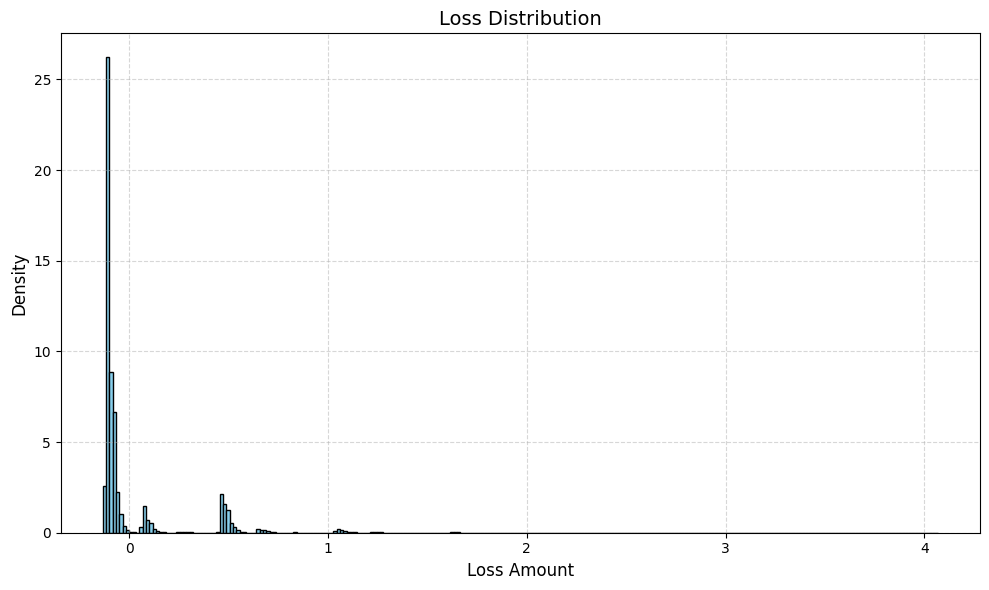

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(losses_ex2a, bins=250, density=True, color='skyblue', edgecolor='black')
plt.title("Loss Distribution", fontsize=14)
plt.xlabel("Loss Amount", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

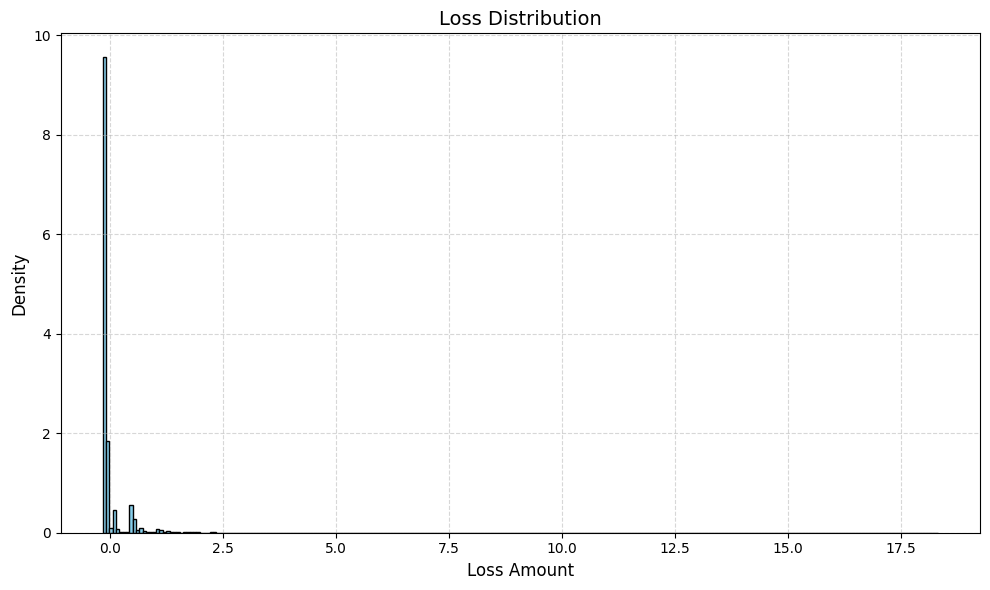

In [32]:

plt.figure(figsize=(10, 6))
plt.hist(losses_ex2b, bins=250, density=True, color='skyblue', edgecolor='black')
plt.title("Loss Distribution", fontsize=14)
plt.xlabel("Loss Amount", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
